170862 	    José Dorivaldo Nascimento Souza Junior 

211845 	    Camila Steffane Fernandes Teixeira Moura 

262891 	    Jing Yang

226078 	    Tiago Moreira Trocoli da Cunha 

<br>**Introduction to Robotics - Assignment 1**<br> 

<br>

Required Libraries

In [30]:
import vrep # access all the VREPelements
import sys
import time
import signal
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance
from math import sin, cos, atan2, sqrt
# import skfuzzy as fuzz
# from skfuzzy import control as ctrl

Connection

In [31]:
def connection_vrep():
    vrep.simxFinish(-1) # just in case, close all opened connections
    clientID=vrep.simxStart("127.0.0.1",19997,True,True,5000,5) # start a connection
    if clientID!=-1:
        print ("Connected to remote API server")
    else:
        print("Not connected to remote API server")
        
    return clientID

clientID = connection_vrep()

Connected to remote API server


Constants

In [32]:
# Put Constants here (e.g. sensors name, limit of time)

ROBOT = "Pioneer_p3dx"

# Sensors
LEFT_MOTOR = 'Pioneer_p3dx_leftMotor'
RIGHT_MOTOR = 'Pioneer_p3dx_rightMotor'
SONAR_SENSORS = "Pioneer_p3dx_ultrasonicSensor"

# Wheels
LEFT_WHEEL = 'Pioneer_p3dx_leftWheel'
RIGHT_WHEEL = 'Pioneer_p3dx_rightWheel'

# Dimensions
WHEEL_DIAMETER = 195 * 10e-4
WHEEL_RADIUS = WHEEL_DIAMETER / 2
ROBOT_WIDTH = 0.381

# Maximum distance for sonar sensors to detect
NO_DETECTION_DIST = 5

# robot stops when reach a timeout
ROBOT_TIMEOUT = 120

# Time interval in which the position of the robot will be checked/calculated.
INTERVAL_CHECK_POSITION = 0.3

# Plot limits
X_LEFT_LIM = 5.5530
X_RIGHT_LIM = -6.8010
Y_BOTTOM_LIM = 6.9940
Y_UPPER_LIM = -5.0660

# Velocity paramenter of the braitenberg function
ROBOT_VELOCITY = 0.5

Function to set handlers

In [33]:
def get_handles():

    # Initialize all handles here

    # Robots
    err_code,robot_handle = vrep.simxGetObjectHandle(clientID, ROBOT, vrep.simx_opmode_blocking)

    # Motors
    err_code,l_motor_handle = vrep.simxGetObjectHandle(clientID, LEFT_MOTOR, vrep.simx_opmode_blocking)
    err_code,r_motor_handle = vrep.simxGetObjectHandle(clientID, RIGHT_MOTOR, vrep.simx_opmode_blocking)

    # Wheels
    err_code,l_wheel_handle = vrep.simxGetObjectHandle(clientID, LEFT_WHEEL, vrep.simx_opmode_blocking)
    err_code,r_wheel_handle = vrep.simxGetObjectHandle(clientID, RIGHT_WHEEL, vrep.simx_opmode_blocking)

    # Sensors
    sonar_sensor_handles = []
    for i in range(1,17):
        err_code,sonar_handle = vrep.simxGetObjectHandle(clientID, SONAR_SENSORS + str(i), vrep.simx_opmode_blocking)
        sonar_sensor_handles.append(sonar_handle)
        
    return robot_handle, l_motor_handle, r_motor_handle, l_wheel_handle, r_wheel_handle, sonar_sensor_handles

robot_handle, l_motor_handle, r_motor_handle, l_wheel_handle, r_wheel_handle, sonar_sensor_handles = get_handles()


Constant Initialization

In [34]:
# Distance between the wheels
err_code, lw = vrep.simxGetObjectPosition(clientID, l_wheel_handle, -1, vrep.simx_opmode_streaming)
while err_code != vrep.simx_return_ok:
    err_code, lw = vrep.simxGetObjectPosition(clientID, l_wheel_handle, -1, vrep.simx_opmode_buffer)
err_code, rw = vrep.simxGetObjectPosition(clientID, r_wheel_handle, -1, vrep.simx_opmode_streaming)
while err_code != vrep.simx_return_ok:
    err_code, rw = vrep.simxGetObjectPosition(clientID, r_wheel_handle, -1, vrep.simx_opmode_buffer)

DISTANCE_BETWEEN_WHEELS = distance.euclidean(lw[:2], rw[:2])

# Initial Position of the Robot
err_code, robot_pos = vrep.simxGetObjectPosition(clientID, robot_handle, -1, vrep.simx_opmode_streaming)
while err_code != vrep.simx_return_ok:
    err_code, robot_pos = vrep.simxGetObjectPosition(clientID, robot_handle, -1, vrep.simx_opmode_buffer)
    
# Only X and Y
ROBOT_INIT_XY = robot_pos[:2]
    
# Initial Orientation of the Robot
err_code, robot_ori = vrep.simxGetObjectOrientation(clientID, robot_handle, -1, vrep.simx_opmode_streaming)
while err_code != vrep.simx_return_ok:
    err_code, robot_ori = vrep.simxGetObjectOrientation(clientID, robot_handle, -1, vrep.simx_opmode_buffer)
    
# Only Gamma
ROBOT_INIT_THETA = robot_ori[2]

# get the relative positions of the sensors from the robot
sonar_positions_xy = []
for i in range(16):
    res, position = vrep.simxGetObjectPosition(clientID, sonar_sensor_handles[i], robot_handle, vrep.simx_opmode_streaming)
    while res != vrep.simx_return_ok :
        res, position = vrep.simxGetObjectPosition(clientID, sonar_sensor_handles[i], robot_handle, vrep.simx_opmode_buffer)

    sonar_positions_xy.append(position[:2])
    
#get the norm and the angle of the sensors relative to the robot
sonar_positions_norm_theta = []
i = 0
for [x,y] in sonar_positions_xy:
    i += 1
    norm = np.linalg.norm([x,y])
    
    if x > 0 and y >= 0:
        theta = np.arctan(y/x)
    elif x == 0 and y >= 0:
        theta = np.arctan(np.inf)
    elif x < 0 and y >= 0:
        theta = np.pi - np.arcsin(y/norm)
    elif x < 0 and y < 0:
        theta = np.pi + np.arctan(y/x)
    elif x >= 0 and y < 0:
        theta = 2*np.pi - np.arccos(y/norm)
        
    sonar_positions_norm_theta.append([norm, theta])


# Sonar sensor transformation matrices
TS = []

sonar_positions_orientations = np.vstack([np.asarray(sonar_positions_xy)[:,0],
                                          np.asarray(sonar_positions_xy)[:,1],
                                          np.asarray(sonar_positions_norm_theta)[:,1]]).T

for x,y,theta in sonar_positions_orientations:
    TS.append(np.array([[np.cos(theta), -np.sin(theta), x],
                        [np.sin(theta),  np.cos(theta), y],
                        [0,              0,             1]]))
    
position_ground_truth = []
position_odometry = []
points_cloud_ground_truth = []
points_cloud_odometry = []

**Base Functions<br>**

In [35]:
def points_transformation_collection(points,trans_matrix, points_source):
    """
        Transform points collected by sensors to global coordinate and restore all the points
        
        Inputs:
        points: points to be transformed 
        trans_matrix: robot position in the global frame
        points_source: 'gt' robot position from ground truth, 'od' robot position from odometry.
    """       
    # TR is a transformation matrix that transform points from robot frame to global frame.
    TR = np.array([[np.cos(trans_matrix[2]), -np.sin(trans_matrix[2]), trans_matrix[0]],
                   [np.sin(trans_matrix[2]),  np.cos(trans_matrix[2]), trans_matrix[1]],
                   [0,                        0,                       1             ]])

    for p in range(len(points)):
        
        if points[p][0] == 100: # if first value of points is 100, it is an undetected point.
            continue
        
        collected_points_global = np.dot(TR,TS[p].dot(np.asarray(points[p])))
        
        if points_source == 'gt':
            points_cloud_ground_truth.append(collected_points_global)  
        elif points_source == 'od':
            points_cloud_odometry.append(collected_points_global)
            
def get_current_position(object_handle, parent_handle):
    """
            Gives the current handle position on the environment.
            Returns:
                    position: Array with the (x,y,z) coordinates.
    """
    res, position = vrep.simxGetObjectPosition(clientID, object_handle, parent_handle, vrep.simx_opmode_streaming)
    while(res != vrep.simx_return_ok):
        res, position = vrep.simxGetObjectPosition(clientID, object_handle, parent_handle, vrep.simx_opmode_streaming)

    return position

def get_current_orientation(object_handle, parent_handle):
    """
            Gives the current object orientation on the environment.
            Returns:
                    orientation: Array with the euler angles (alpha, beta and gamma).
    """
    res, orientation = vrep.simxGetObjectOrientation(clientID, object_handle, parent_handle, vrep.simx_opmode_streaming)
    while(res != vrep.simx_return_ok):
        res, orientation = vrep.simxGetObjectOrientation(clientID, object_handle, parent_handle, vrep.simx_opmode_streaming)

    return orientation

def set_velocity_one_motor(motor, v):
    """ set velocity to an specific motor """
    
    try:
        motor = motor.lower()

        if motor == "l" or motor == "left":
            err_code = vrep.simxSetJointTargetVelocity(clientID,l_motor_handle,v,
                                                       vrep.simx_opmode_streaming)
        elif motor == "r" or motor == "right":
            err_code = vrep.simxSetJointTargetVelocity(clientID,r_motor_handle,v,
                                                      vrep.simx_opmode_streaming)
    except Exception as e:
        raise e

        
def set_velocity_both_motors(v):
    """ set the same velocity to both motors """
    
    try:
        set_velocity_one_motor("l", v)
        set_velocity_one_motor("r", v)
    except Exception as e:
        raise e
    

def difference_radians(rad1, rad2):
    """ difference between two radians """
    
    try:
        if rad1 <= rad2:
            return rad2 - rad1
        elif 0 <= rad2 <= np.pi and np.pi <= rad1 <= 2*np.pi:
            return (np.pi - rad1) + (rad2 + np.pi)
        else:
            return 0
    except Exception as e:
        raise e
        
        
def read_sonar_sensors(ini=1, end=17):
    """
            Reads the distances from the 16 ultrassonic sensors.
            Returns:
                    distances: List with the distances in meters.
    """
    Distances = []
    noDetectionDist = 5.0 #Here we define the maximum distance as 5 meters

    for i in range(ini,end):
        res, status, distance,_,_ = vrep.simxReadProximitySensor(clientID, sonar_sensor_handles[i-1], vrep.simx_opmode_streaming)
        while(res != vrep.simx_return_ok):
            res, status, distance,_,_ = vrep.simxReadProximitySensor(clientID, sonar_sensor_handles[i-1], vrep.simx_opmode_buffer)

        if(status != 0):
            Distances.append(distance[2])
        else:
            Distances.append(noDetectionDist)
    
    return Distances

        
def get_position(object_handle, parent_handle):
    """ get the positions of an object in relation to a parent """
    
    try:
        res, position = vrep.simxGetObjectPosition(clientID, object_handle, parent_handle, vrep.simx_opmode_streaming)
        while(res != vrep.simx_return_ok):
            res, position = vrep.simxGetObjectPosition(clientID, object_handle, parent_handle, vrep.simx_opmode_buffer)
    
        return position
    except Exception as e:
        raise e

def get_orientation(object_handle, parent_handle):
    """ get the orientation of an object in relation to a parent """
    
    try:
        res, ori = vrep.simxGetObjectOrientation(clientID, object_handle, parent_handle, vrep.simx_opmode_streaming)
        while(res != vrep.simx_return_ok):
            res, ori = vrep.simxGetObjectOrientation(clientID, object_handle, parent_handle, vrep.simx_opmode_buffer)

        return ori
    except Exception as e:
        raise e

def get_joint_position(object_handle):
    """ get joint position of an object """
    
    try:
        err_code, angle = vrep.simxGetJointPosition(clientID, object_handle, vrep.simx_opmode_streaming)
        while err_code != vrep.simx_return_ok:
            err_code, angle = vrep.simxGetJointPosition(clientID, object_handle, vrep.simx_opmode_buffer)

        return angle
    except Exception as e:
        raise e
    
def odometry_new_pos(ini_pos, left_rad, right_rad):
    """ calculate new odometry given old position and wheels radial displacement """
    
    try:
        delta_s = WHEEL_RADIUS * (left_rad + right_rad) / 2
        delta_theta = WHEEL_RADIUS * (right_rad - left_rad) / DISTANCE_BETWEEN_WHEELS

        new_pos = [0.0,0.0,0.0]
        new_pos[0] = ini_pos[0] + (delta_s * cos(ini_pos[2] + (delta_theta/2)))
        new_pos[1] = ini_pos[1] + (delta_s * sin(ini_pos[2] + (delta_theta/2)))
        new_pos[2] = ini_pos[2] + delta_theta

        return new_pos
    except Exception as e:
        raise e
        
def collect_odometry(ini_pos, ini_left_angle, ini_right_angle):
    """ checks odometry and stores in the global array """
    
    try:
        new_left_angle = get_joint_position(l_motor_handle)
        new_right_angle = get_joint_position(r_motor_handle)

        left_angle_diff = difference_radians(ini_left_angle, new_left_angle)
        right_angle_diff = difference_radians(ini_right_angle, new_right_angle)

        robot_new_odometry = odometry_new_pos(ini_pos, left_angle_diff, right_angle_diff)

        position_odometry.append(robot_new_odometry)

        return robot_new_odometry, new_left_angle, new_right_angle
    except Exception as e:
        raise e

def collect_ground_truth():
    """ checks the ground truth and stores in the global array""" 
    
    try:
        robot_pos_gt = get_position(robot_handle,-1)[:2] + [get_orientation(robot_handle, -1)[2]]
        position_ground_truth.append(robot_pos_gt)
        return robot_pos_gt
    except Exception as e:
        raise e
        

def walk_straight_meters(m, end_vel=0, robot_pos_odometry=[0,0,0]):
    """ the robot walks a pre-determined quantity of meters """
    
    try:
        
        wheels_radians_required = m / (WHEEL_DIAMETER / 2)
        set_velocity_both_motors(ROBOT_VELOCITY)
        
        ini_left_angle = get_joint_position(l_motor_handle)
        ini_right_angle = get_joint_position(r_motor_handle)
        
        while wheels_radians_required > 0:
            # robot position - ground truth (x, y, theta)
            robot_pos_gt = collect_ground_truth()
            
            # robot odometry
            robot_new_odometry, new_left_angle, new_right_angle = collect_odometry(robot_pos_odometry, 
                                                                                   ini_left_angle,
                                                                                   ini_right_angle)
            
            robot_pos_odometry = robot_new_odometry
            
            wheels_radians_required -= difference_radians(ini_left_angle, new_left_angle)
            
            ini_left_angle = new_left_angle
            ini_right_angle = new_right_angle
            
            all_detected_points, all_distances = read_sonar_sensors()
            
            points_transformation_collection(all_detected_points, position_ground_truth[-1], 'gt')
            points_transformation_collection(all_detected_points, position_odometry[-1], 'od')
            
            # only checks the frontal sonar sensor
            if all_distances[3] < NO_DETECTION_DIST / 2:
                wheels_radians_required = 0
                set_velocity_both_motors(0)
            
            time.sleep(INTERVAL_CHECK_POSITION)
            
        set_velocity_both_motors(0)
        
        return robot_pos_odometry
    except Exception as e:
        raise e
        

def spin_robot(angle, direction='l', odo_current_position=[0,0,0], v=0, odometry=True, ground_truth=True, method='odo'):
    """ turns the robot to an specific angle 
        angle in radians
    """
    if method == 'odo':
        try:
            direction = direction.lower()

            if direction in ("left", "l"):
                m_0, m_1 = "l", "r"
                motor_handle = r_motor_handle
            elif direction in ("right", "r"):
                m_0, m_1 = "r", "l"
                motor_handle = l_motor_handle

            # initial radian position of the wheel
            ini_angle = get_joint_position(motor_handle)

            wheels_radians_required = (DISTANCE_BETWEEN_WHEELS / 2) * angle / (WHEEL_DIAMETER / 2)

            set_velocity_one_motor(m_0, -ROBOT_VELOCITY)
            set_velocity_one_motor(m_1, ROBOT_VELOCITY)

            while wheels_radians_required > 0:
                new_angle = get_joint_position(motor_handle)

                diff_radians = difference_radians(ini_angle, new_angle)
                wheels_radians_required -= diff_radians

                if ground_truth is True:
                    collect_ground_truth()

                if odometry is True:
                    if m_1 == 'l':
                        odo_new_position = odometry_new_pos(odo_current_position, diff_radians, -diff_radians)
                    elif m_1 == 'r':
                        odo_new_position = odometry_new_pos(odo_current_position, -diff_radians, diff_radians)

                    odo_current_position = odo_new_position
                    position_odometry.append(odo_current_position)

                ini_angle = new_angle

                time.sleep(INTERVAL_CHECK_POSITION)

            if v is None:
                set_velocity_one_motor(m_0, vlinear_0)
                set_velocity_one_motor(m_1, vlinear_1)
            else:
                set_velocity_both_motors(v)

            return odo_current_position

        except Exception as e:
            raise e
    elif method == 'timer':
        direction = direction.lower()

        if direction in ("left", "l"):
            m_0 = 1
            # motor_handle = self.motors_handle["left"]
        elif direction in ("right", "r"):
            m_0 = -1
            # motor_handle = self.motors_handle["right"]

        W = 0.4
        wheels_radians_required = (ROBOT_WIDTH / 2) * angle / (WHEEL_RADIUS)
        T = wheels_radians_required / W
        # print(T)
        start = time.time()
        set_velocity_one_motor('l', -m_0*W)
        set_velocity_one_motor('r', m_0*W)
        end = time.time()
        while (end - start)<T:
            end = time.time()
        set_velocity_both_motors(0)
        time.sleep(0.5)


def get_wheels_velocity():
        """
        Gives the current velocity of both wheels.
        Returns:
                position: Array with current angular velocity of left and right wheels.
        """
        res, l_vel, a_vel = vrep.simxGetObjectVelocity(clientID, robot_handle, vrep.simx_opmode_streaming)
        while(res != vrep.simx_return_ok):
                res, l_vel, a_vel = vrep.simxGetObjectVelocity(clientID, robot_handle, vrep.simx_opmode_streaming)

        V = np.sqrt(l_vel[0]**2 + l_vel[1]**2)
        W = a_vel[2]
        left_vel = (V - W*(ROBOT_WIDTH/2))/WHEEL_RADIUS
        right_vel = (V + W*(ROBOT_WIDTH/2))/WHEEL_RADIUS

        return left_vel, right_vel
        # return V,W
        
def set_pos_ori_robot(x,y,gamma):
    """ set both the position (x, y) and the orientation (gamma) of the robot """
    #vrep.simxSetObjectPosition(clientID, robot_handle, -1, [-1.2500e+00, -3.7500e+00, +1.3879e-01],
    #vrep.simx_opmode_oneshot)
    vrep.simxSetObjectPosition(clientID, robot_handle, -1, [x, y, +1.3879e-01],
                               vrep.simx_opmode_oneshot)
    vrep.simxSetObjectOrientation(clientID, robot_handle, -1, [0.0000e+00, 0.0000e+00, gamma],
                                  vrep.simx_opmode_oneshot)
    
def plot_points_map(points, title, lims=True):
    plt.figure(dpi=1080)
    plt.plot(*zip(*points))
    
    if lims == True:
        plt.xlim(X_LEFT_LIM, X_RIGHT_LIM)
        plt.ylim(Y_BOTTOM_LIM, Y_UPPER_LIM)
    plt.title(title)
    plt.show()

def plot_points_map3(points, title, lims=True):
    
    plt.figure(dpi=1080)
    plt.plot(*zip(*points))
    
    if lims == True:
        plt.xlim(X_LEFT_LIM, X_RIGHT_LIM)
        plt.ylim(Y_BOTTOM_LIM, Y_UPPER_LIM)
    plt.xlabel('x (meter)')
    plt.ylabel('y (meter)')
    
    plt.plot(x_1, y_1, 'xb')
    plt.text(x_1, y_1, '({:.1f}, {:.1f})'.format(x_1, y_1))
    plt.plot(x_2, y_2, 'xb')
    plt.text(x_2, y_2, '({:.1f}, {:.1f})'.format(x_2, y_2))
    plt.plot(x_3, y_3, 'xb')
    plt.text(x_3, y_3, '({:.1f}, {:.1f})'.format(x_3, y_3))
    
    plt.title(title)
    plt.show()

**Proportional Controller Wall Follow**

We have implemented a *Proportional Controller Wall Follow Method*. In this method, as its name suggests, the robot walks alongside a wall, adjusting the velocity of both wheels to keep a certain distance from that. The method's parameters are a position goal, a base velocity, a *Kp*, and a timeout.

Proportional Controller, by definition, uses the factor Kp and the difference between the measured distance and the goal distance from the wall to calculate the velocities in both. In this work, the distance is measured by the sonar sensor 1 (Henceforth it will be called *side sonar*). 

This method with two improvements:

1 - In each iteration, the sonar sensor 5 (henceforth it will be called *front sonar*) is checked. If the distance is lesser than the position goal, the robot should turn 90º degrees, which is an approximate angle distance between the side sonar and the front sonar.

2 - The Proportional Controller Equation returns *u*, and the new velocity is set as *base_velocity + u* for the left wheel and *base_velocity - u* for the right wheel. In order to avoid strange velocities, we defined that the velocities of both wheels should be between [0, 2*base_velocity]

In [36]:
def pc_wall_follow(position_goal=0.2, base_velocity=0.5, Kp=16, robot_timeout=ROBOT_TIMEOUT):
    # Inner function that will be set to be executed when the robot should stop
    def handler_timeout(signum, frame):
        """ just a timeout handler :) """
        raise Exception

    try:
        vrep.simxStartSimulation(clientID,vrep.simx_opmode_blocking)
        # Set the signal to stop the robot in ROBOT_TIMEOUT seconds
        signal.signal(signal.SIGALRM, handler_timeout)
        signal.alarm(robot_timeout)
        
        dist = 0
        # set an initial velocity
        vel = base_velocity
        set_velocity_both_motors(vel)
        # define which sonars are the front and the side sonars
        front_sonar = 5
        side_sonar = 1
        found = False

        while True:
            distances = read_sonar_sensors()
            
            collect_ground_truth()

            if distances[front_sonar-1] < position_goal:
                # if the front sonar has just detected something, the robot should
                # turn, otherwise it will bump with the obstacle soon
                
                spin_robot(np.pi/2, 'r', v=base_velocity)
            elif distances[side_sonar-1] < NO_DETECTION_DIST or found is True:
                # if the side sonar has already detected something, apply PD Controller
                
                dist = distances[side_sonar-1]
                error = (position_goal - dist)
                u = Kp * error
                old_error = error

                # Estimate the new velocities with boundaries min
                # and max, as otherwise the new velocities could 
                # be too high or negative.
                vel_l = min(max(0, base_velocity + u), 2*base_velocity)
                vel_r = min(max(0, base_velocity - u), 2*base_velocity)

                set_velocity_one_motor('l', vel_l)
                set_velocity_one_motor('r', vel_r)

                found = True
            else:
                set_velocity_both_motors(vel)
            
            time.sleep(0.1)
    except KeyboardInterrupt:
        set_velocity_both_motors(0)
        vrep.simxStopSimulation(clientID,vrep.simx_opmode_blocking)
    except Exception as e:
        print(e)
        set_velocity_both_motors(0)
        vrep.simxStopSimulation(clientID,vrep.simx_opmode_blocking)
        plot_points_map(np.asarray(position_ground_truth)[:,:2], 
                        "PID Wall Follow - KP=" + str(Kp) + "; V=" 
                        + str(base_velocity) + "; PG=" + 
                        str(position_goal) + "; TIME=" + 
                        str(robot_timeout) + " sec")

Using the scenario p3dx_only_doors.ttt, we have decided that the best parameters are:


*position_goal = 0.2<br>base_velocity = 0.5<br>Kp = 16<br>*

Let's initially start the robot in the following position and orientation: 


*x = -1.2500e+00<br>y = -3.7500e+00<br>gamma = -1.8530e+02*


![scenario with no obstacles](no-items-env-3.png)

In [ ]:
# restarting some connection functions, as it could be a new scenario
vrep.simxLoadScene(clientID, os.getcwd() + "/p3dx_only_doors.ttt", 0, vrep.simx_opmode_blocking)
clientID = connection_vrep()
robot_handle, l_motor_handle, r_motor_handle, l_wheel_handle, r_wheel_handle, sonar_sensor_handles = get_handles()

set_pos_ori_robot(x=-1.2500e+00, y=-3.7500e+00, gamma=-1.8530e+02)

pc_wall_follow(position_goal=0.2, base_velocity=0.5, Kp=16, robot_timeout=ROBOT_TIMEOUT)

The method works even if wall is not entirely plane. For instance, if the robot is in the position and orientation

*x = +2.2750e+00<br>y = -4.6500e+00<br>gamma = -1.8530e+02*

If the robot walks straight, the robot will have to follow the sliding door (instead of a wall). The graph shows us that the robot, even with some unstability, can work around this drawback.

![close to sliding door](close-to-sliding-door.png)

In [ ]:
set_pos_ori_robot(x=+2.2750e+00, y=-4.6500e+00, gamma=-1.8530e+02)

position_ground_truth = []
pc_wall_follow(position_goal=0.2, base_velocity=0.5, Kp=16, robot_timeout=ROBOT_TIMEOUT)

The method has at least one flaw: As for collision avoidance only one sonar sensor are used (front sonar), the robot might get closer to an object in a way that the front sonar does not detect it, and then collide with that. One way to work around it could be the method consider more sonars sensors, but this would cause more unstability to the method.

This might happen, for instance, with the door in the environment which leads to the room with two windows. Setting the position and orientation to: 

*x = -6.3500e+00<br>y = +1.1250e+00<br>z = +1.3879e-01<br>gamma = +2.0410e+01*

![scenario with no obstacles](no-items-env-4.png)

In [ ]:
set_pos_ori_robot(x=-6.3500e+00, y=+1.1250e+00, gamma=+2.0410e+01)

position_ground_truth = []

pc_wall_follow(position_goal=0.2, base_velocity=0.5, Kp=16, robot_timeout=ROBOT_TIMEOUT)

![scenario with no obstacles](stucked-robot-2.png)

Setting a higher velocity brings more unstability and enhance the consequences of the fails that this method has. For instance, lets the following parameters:

*position_goal = 0.5<br>base_velocity = 5<br>Kp = 2*

And the position and orientation:

*x = -6.3500e+00<br>y = -3.4750e+00<br>gamma = +8.9407e+01*

![scenario with no obstacles](fast-beg.png)

In [ ]:
set_pos_ori_robot(x=-6.3500e+00, y=-3.4750e+00, gamma=+8.9407e+01)

position_ground_truth = []

pc_wall_follow(position_goal=0.5, base_velocity=5, Kp=2, robot_timeout=ROBOT_TIMEOUT)

In the test that was made, the robot can't left the room and bumps in the corner of the door.

![scenario with no obstacles](fast-end.png)

Finally, running this behavior in the original scenario, with all obstacles *(p3dx_standard.ttt)*, may highlights that with this method the robot can follow the wall even with the objects. Starting the robot in the position:

*x = +4.3750e+00<br>y = -7.2500e-01<br>gamma = -9.0000e+01*

![full_scenario](full-scenario-2.png)

In [ ]:
# restarting some connection functions, as it could be a new scenario
vrep.simxCloseScene(clientID, vrep.simx_opmode_blocking)
vrep.simxLoadScene(clientID, os.getcwd() + "/p3dx_standard.ttt", 0, vrep.simx_opmode_blocking)
clientID = connection_vrep()
robot_handle, l_motor_handle, r_motor_handle, l_wheel_handle, r_wheel_handle, sonar_sensor_handles = get_handles()

set_pos_ori_robot(x=+4.3750e+00, y=-7.2500e-01, gamma = -9.0000e+01)

position_ground_truth = []

pc_wall_follow(position_goal=0.2, base_velocity=0.5, Kp=16, robot_timeout=ROBOT_TIMEOUT)

**GoToGoal with PID**

The goToGoal algorithm sets a constant velocity magnitude $v$ and corrects its direction (angle) periodically, using equation \ref{atan2}, \ref{error} and \ref{pid}. Moreover, to correct the direction, its wheels must change angular velocity using equation \ref{velocity} and $\omega$ from PID.

GoToGoal uses unicycle kinematics model, that is a more natural and simple way to control the robot. In that model, we want the robot to move with velocity magnitude ($v$) and direction ($\omega$), that is: 

\begin{equation}
\label{velocity} \tag{1}
v_{right} = \frac{(2v + \omega L)}{2r} \\
v_{left} = \frac{(2v - \omega L)}{2r}
\end{equation}
in which $L$ and $r$ is the distance between wheels and their radius, respectively.

The robot needs to go from position $(0,0)$ to $(x_d, y_d)$.
Thus, the it needs to turn to an angle $\theta_d$:

\begin{equation}
\label{atan2} \tag{2}
\theta_d = atan2(\frac{y_d - y}{x_d - x})
\end{equation}

But, given that the head of robot makes an angle of $\theta$ to the origin, therefore, it needs to turn: 

\begin{equation}
\label{error} \tag{3}
e = \theta_d - \theta
\end{equation}

However, the robot turns while moving, so the PID controls this angle (velocity direction):
\begin{equation}
\label{pid} \tag{4}
\omega = PID(e) = K_p e + K_i \sum_{i=1}^{n} e_i + K_d (e - e_{old}),
\end{equation}
in which $K_p$, $K_i$ and $K_d$ is the proportional, integral and derivative weights, respectively.

In [ ]:
x_1 = 0 
y_1 = 0
x_2 = 0
y_2 = 0 
x_3 = 0 
x_3 = 0

# integral part of PID
i_e = 0
# used in derivative part of PID
old_e = 0
# odometry parameters:
robot_pos_odometry = collect_ground_truth()
ini_left_angle = get_joint_position(l_motor_handle)
ini_right_angle = get_joint_position(r_motor_handle)


def reset_param():
    global position_ground_truth, robot_pos_odometry, position_odometry, ini_left_angle, ini_right_angle, old_e, i_e
    
    vrep.simxStopSimulation(clientID,vrep.simx_opmode_blocking)
    time.sleep(1)
    vrep.simxStartSimulation(clientID,vrep.simx_opmode_blocking)
    position_ground_truth = []
    position_odometry = []
    robot_pos_odometry = collect_ground_truth()
    ini_left_angle = get_joint_position(l_motor_handle)
    ini_right_angle = get_joint_position(r_motor_handle)
    old_e = 0
    i_e = 0
    
#  unicycle model kinematics
def set_velocity(v, omega):
    # v = velocity
    # omega = angle
    
    v_r = (2*v + (omega)*DISTANCE_BETWEEN_WHEELS)/(2.0*WHEEL_RADIUS)
    v_l = (2*v - (omega)*DISTANCE_BETWEEN_WHEELS)/(2.0*WHEEL_RADIUS)
    set_velocity_one_motor("left", v_l)
    set_velocity_one_motor("right", v_r)

def PID(k_p, k_i, k_d, e):
    # e = error
    global i_e, old_e
    i_e = i_e + e
    res = k_p*e + k_i*i_e + k_d*(e - old_e) 
    old_e = e
    return res

def robotOdometry():
    global robot_pos_odometry, ini_left_angle, ini_right_angle
    
    robot_new_odometry, new_left_angle, new_right_angle = collect_odometry(robot_pos_odometry, ini_left_angle, ini_right_angle)
    robot_pos_odometry = robot_new_odometry
    ini_left_angle = new_left_angle
    ini_right_angle = new_right_angle

def angle_threshold(angle):
    
    if angle > (np.pi/6.0):
        return (np.pi/6.0)
    if angle < -(np.pi/6.0):
        return -(np.pi/6.0)
    return angle
    
def goToGoal_odometry(velocity, position_goal):
    
    #reset_param()
    
    x_d, y_d = position_goal
    x = x_d + 1
    y = y_d + 1
    
    while(sqrt((x-x_d)**2 + (y-y_d)**2) > 0.1):
        
        x, y, angle_old = robot_pos_odometry
        angle_d = atan2(y_d - y, x_d - x)
        angle = PID(0.75, 0, 0, angle_d - angle_old)
        robotOdometry()
        collect_ground_truth()
        set_velocity(velocity, angle)
        time.sleep(INTERVAL_CHECK_POSITION)
        
    set_velocity_both_motors(0)


def goToGoal_groundTruth(velocity, position_goal):
    
    #reset_param()
    
    x_d, y_d = position_goal
    x = x_d + 1
    y = y_d + 1
    
    while(sqrt((x-x_d)**2 + (y-y_d)**2) > 0.1):
        
        x, y, angle_old = collect_ground_truth()
        angle_d = atan2(y_d - y, x_d - x)
        angle = PID(0.75, 0, 0, angle_d - angle_old)
        set_velocity(velocity, angle)
        time.sleep(INTERVAL_CHECK_POSITION)
        
    set_velocity_both_motors(0)

**GoToGoal Behavior**

We set up 3 experiments to evaluate goToGoal behavior. The robot needs to go to three points, forming a triangular path as depicted below. In the first movement, we want to evaluate goToGoal for a straight path *(in p3dx_only_doors.ttt)*, that is the easier path. In the second and third movements, we want to evaluate it when the robot needs to turn more than 90° and less than 45º, respectively.

<img src="triangular_path.png">
<img src="standard-no-walls.png">

1) GoToGoal with ground-truth

As we can see, the path is almost perfect. It is very similar to a triangular shape, except for small curves at points $(1.9, -0.8)$ and $(0.3, -2.7)$. That was expected, since the robot turns while moving and $k_p$ was also small preventing abrupt turns.

In [ ]:
# restarting some connection functions, as it could be a new scenario
vrep.simxCloseScene(clientID, vrep.simx_opmode_blocking)
vrep.simxLoadScene(clientID, os.getcwd() + "/p3dx_only_doors.ttt", 0, vrep.simx_opmode_blocking)
clientID = connection_vrep()
robot_handle, l_motor_handle, r_motor_handle, l_wheel_handle, r_wheel_handle, sonar_sensor_handles = get_handles()

reset_param()
goToGoal_groundTruth(0.05, [2,-0.8250])
points   = np.asarray(position_ground_truth)[:,:2]
x_1, y_1 = points[-1]
goToGoal_groundTruth(0.05, [0.25, -2.7750]) 
points   = np.asarray(position_ground_truth)[:,:2] 
x_2, y_2 = points[-1] 
goToGoal_groundTruth(0.05, [-2,-0.8250]) 
points   = np.asarray(position_ground_truth)[:,:2] 
x_3, y_3 = points[-1]
plot_points_map3(points,  "GotoGoal with PID using Groundtruth.")

2) GoToGoal using odometry: odometry path

We can easily see that the robot indeed reached the supposed target points. However, due to odometry errors, the robot could not reach the last point since it headed towards wall.

In [ ]:
reset_param()
goToGoal_odometry(0.05, [2,-0.8250])
points   = np.asarray(position_odometry)[:,:2]
x_1, y_1 = points[-1]
goToGoal_odometry(0.05, [0.25, -2.7750]) 
points   = np.asarray(position_odometry)[:,:2] 
x_2, y_2 = points[-1]
# goToGoal_odometry(0.05, [-2.725,0.325]) 
# points   = np.asarray(position_odometry)[:,:2] 
x_3, y_3 = points[-1]
plot_points_map3(points,  "GotoGoal with PID using Odometry: Odometry path")

3) GoToGoal using odometry: ground-truth path

The ground-truth path image below shows the path that robot de facto moved. We can see that for a straight path, $(-2, -0.825) \rightarrow (2,-0.825)$, odometry and ground-truth is almost the same. That is not happened when the robot needed to turn, making large errors what caused a totaly different path. 

In [ ]:
#reset_param()
#goToGoal_odometry(0.05, [2,-0.8250])
points   = np.asarray(position_ground_truth)[:,:2]
x_1, y_1 = points[-1]
#goToGoal_odometry(0.05, [0.25, -2.7750]) 
points   = np.asarray(position_ground_truth)[:,:2]
x_2, y_2 = points[-1] 
# goToGoal_groundTruth(0.05, [-2.725,0.325])
# points   = np.asarray(position_ground_truth)[:,:2] 
x_3, y_3 = points[-1]
plot_points_map3(points,  "GotoGoal with PID using Odometry: Groundtruth path")

In [ ]:
set_velocity_both_motors(0)
vrep.simxStopSimulation(clientID,vrep.simx_opmode_blocking)

<br>**Fuzzy Aproach for obstance avoidance**


First of all, we defined an input, it means one input (antecedent) per sensor. After that, we defined the close and away sets, using a trapezoidal function, defined by:

<img src="camila-trapezoidal-fuzzy.png">

where $a$ is the lower limit, an $d$ is upper limit, $b$ is lower support limit, $c$ is an upper support limit, and $a < b < c < d$.


We define two outputs (consequent) in wich each of them set a velocity in the motor -left and right. After that, we also defined the positive and negative velocity sets, using a triangular function:

<img src="camila-triangular-fuzzy.png">

where $a$ (-velocity) is lower limit, $d$ (+velocity) is upper limit, $m$ is a value, and $a < m < b$.

We have added 3 rules for each motor, consisting of a set of conditions that imply a consequence. That is, the condition determines whether the obstacle is close or not, which implies a positive or negative resultant speed for each motor, which is belonging to the universe set [-vel_max, + vel_max] according to the results of the condition.

In [ ]:
NUM_SENSORS = 8
max_speed = ROBOT_VELOCITY
min_dist = 0.03
max_dist = 5.0
steps = 0.01

def AO_init_fuzzy():
    """ Create the rules and initialize it """
    
    # For each senor
    ants = []
    for i in range(0, NUM_SENSORS):
        # Create one antecedent (Antecedent (input/sensor) variable for a fuzzy control system)
        ants.append(ctrl.Antecedent(np.arange(0, max_dist, steps), 'dist'+str(i)))
        # Create two trapezoidal membership function generator (One for Close and other to Away)
        ants[i]['c'] = fuzz.trapmf(ants[i].universe, [0.0, 0.0, min_dist*10.0, min_dist*20.0])
        ants[i]['a'] = fuzz.trapmf(ants[i].universe, [min_dist*10.0, min_dist*20.0, max_dist, max_dist])
    
    # Create two Consequent (left speed and right speed) (Consequent (output/control) variable for a fuzzy control system.)
    cons_left = ctrl.Consequent(np.arange(-max_speed, 1.0+max_speed, 0.01), 'speed_left')
    cons_right = ctrl.Consequent(np.arange(-max_speed, 1.0+max_speed, 0.01), 'speed_right')
    
    # Create triangular membership function generator to define positive and negative speeds
    cons_left['pos'] = fuzz.trimf(cons_left.universe, [0.0, max_speed-0.1, max_speed-0.1])
    cons_left['neg'] = fuzz.trimf(cons_left.universe, [-max_speed, -max_speed, 0.0])
    cons_right['pos'] = fuzz.trimf(cons_right.universe, [0.0, max_speed, max_speed])
    cons_right['neg'] = fuzz.trimf(cons_right.universe, [-max_speed+0.1, -max_speed+0.1, 0.0])

    # Rules for left
    rule1 = ctrl.Rule(ants[0]['c'] | ants[1]['c'] | ants[2]['c'] | ants[3]['c'], cons_left['pos'])
    rule2 = ctrl.Rule(ants[4]['c'] | ants[5]['c'] | ants[6]['c'] | ants[7]['c'], cons_left['neg'])
    rule3 = ctrl.Rule(ants[0]['a'] & ants[1]['a'] & ants[2]['a'] & ants[3]['a'] & ants[4]['a'] & 
                      ants[5]['a'] & ants[6]['a'] & ants[7]['a'], cons_left['pos'])
    
    # Rules for right
    rule4 = ctrl.Rule(ants[0]['c'] | ants[1]['c'] | ants[2]['c'] | ants[3]['c'], cons_right['neg'])
    rule5 = ctrl.Rule(ants[4]['c'] | ants[5]['c'] | ants[6]['c'] | ants[7]['c'], cons_right['pos'])
    rule6 = ctrl.Rule(ants[0]['a'] & ants[1]['a'] & ants[2]['a'] & ants[3]['a'] & ants[4]['a'] & 
                        ants[5]['a'] & ants[6]['a'] & ants[7]['a'], cons_right['pos'])

    # ControlSystem
    control_system = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5, rule6])
    return ctrl.ControlSystemSimulation(control_system)
    

def AO_get_speeds(simulation, distances):
    # Fill inputs
    for i in range(len(distances)):
        simulation.input['dist'+str(i)] = distances[i]
    
    # Compute --- execute fuzzy 
    simulation.compute()
    
    # Get and return results
    return [simulation.output['speed_right'], simulation.output['speed_left']]


In [ ]:
def random_path(robot_timeout=ROBOT_TIMEOUT):
    def handler_timeout(signum, frame):
        """ just a timeout handler :) """
        raise Exception

    try:
        vrep.simxStartSimulation(clientID,vrep.simx_opmode_blocking)
        
        signal.signal(signal.SIGALRM, handler_timeout)
        signal.alarm(robot_timeout)
        
        simulation = AO_init_fuzzy()

        OBST_TRESHOLD = 0.3

        set_velocity_both_motors(ROBOT_VELOCITY)

        while vrep.simxGetConnectionId(clientID) != -1:
            distances = read_sonar_sensors()
            collect_ground_truth()

            if min(distances) < OBST_TRESHOLD:
                vel = AO_get_speeds(simulation, distances[:8])
            else:
                vel = (ROBOT_VELOCITY, ROBOT_VELOCITY)

            set_velocity_one_motor('r',vel[0])
            set_velocity_one_motor('l',vel[1])
            time.sleep(INTERVAL_CHECK_POSITION)

        set_velocity_both_motors(0)
        vrep.simxStopSimulation(clientID,vrep.simx_opmode_blocking)
    except Exception as e:
        print(e)
        set_velocity_both_motors(0)
        vrep.simxStopSimulation(clientID,vrep.simx_opmode_blocking)

Using the scenario *p3dx_obstacle_avoidance.ttt* with obstacles in the initial position.

<img src="oa1.png">

In [ ]:
# restarting some connection functions, as it could be a new scenario
vrep.simxCloseScene(clientID, vrep.simx_opmode_blocking)
vrep.simxLoadScene(clientID, os.getcwd() + "/p3dx_obstacle_avoidance.ttt", 0, vrep.simx_opmode_blocking)
clientID = connection_vrep()
robot_handle, l_motor_handle, r_motor_handle, l_wheel_handle, r_wheel_handle, sonar_sensor_handles = get_handles()

ROBOT_VELOCITY = 0.5
position_ground_truth = []

random_path()

In [ ]:
plot_points_map(np.asarray(position_ground_truth)[:,:2], "Avoid Obstacle: v=0.5")

In [ ]:
ROBOT_VELOCITY = 3
position_ground_truth = []
random_path()

In [ ]:
plot_points_map(np.asarray(position_ground_truth)[:,:2], "Avoid Obstacle: v=3")

Changing the initial positon to:

*x = -4.5000e-01<br>y = +3.5750e+00<br>gamma = +0.0000e+00*

<img src="oa2.png">

In [ ]:
ROBOT_VELOCITY = 1
position_ground_truth = []

set_pos_ori_robot(x=-4.5000e-01, y=+3.5750e+00, gamma=+0.0000e+00)

random_path()

In [ ]:
plot_points_map(np.asarray(position_ground_truth)[:,:2], "Avoid Obstacle: v=3")

Using a scenario with initial position:

*x = -5.7000e+00<br>y = +2.3500e+00<br>gamma = +0.0000e+00*

<img src="oa3.png">

In [ ]:
ROBOT_VELOCITY = 2
position_ground_truth = []

set_pos_ori_robot(x=-5.7000e+00, y=+2.3500e+00, gamma=+0.0000e+00)

random_path(robot_timeout=2*ROBOT_TIMEOUT)

We can see a problem of this method: If the robot is rounded by many objects, the robots avoid the obstacles very slowly, plus the robot may not be able to left the "circle" of objects. In the experiment that we have run, the robot wandered among the objects for 4 minutes, and was not able to left.

In [ ]:
plot_points_map(np.asarray(position_ground_truth)[:,:2], "Avoid Obstacle: v=2")

**Wall Following - Fuzzy**

For the wall following strategy using Fuzzy Logic Controller(FLC), Mamdani method is adopted. The design of the controller is as follows.

**1. Determine the inputs and outputs fuzzy variables**

By observing the sensors of the Pioneer p3dx robot, we found that the robot has two pairs of parallel ultrasonicsensors on the left(sensor 1 and 16) and right(sensor 8 and 9) respectively. Based on this, we decide to use the left pair of sensors and make the robot follow the walls on its left. As sensor 1 and 16 should always obtain very similar values when the robot is parallel to the wall, we define the inputs fuzzy variables as:

\begin{equation}
\begin{array}{l}{\Delta x=x_{1}+x_{2}-2\text{D}} \\ {\Delta d=x_{1}-x_{2}}\end{array}
\end{equation}

where $x_{1}$ ,$x_{2}$ are the distances detected by sonor sensor 1 and 16 respectively, D is a predetermined constant distance that the robot should keep from the wall. $\Delta x$ is deviation from D, which indicates if the robot is closer ($\Delta x<0$) or farther($\Delta x<0$) from the wall, $\Delta d$ is the difference of distances between two sensors, which indicates the orientation of the robot. If $\Delta d>0$, it means the robot is moving away from the wall, if $\Delta d>0$, then robot is getting close to the wall. 

The output variables are the amount of changes of angular velocity of robot's two wheels: $\Delta v_{l}$ and $\Delta v_{r}$. The diagram of the system is shown below:

<img src="Wall-follow-Fuzzy-Diagram.png">

**2. Define membership functions for every variable**

The linguistic values for the input variables $\Delta x$ and $\Delta d$ are Negative, Zero and Positive, for output variables $\Delta v_{l}$  and $\Delta v_{r}$ are also Negative, Zero and Positive. Every variable is assigned with a triangular membership function. And they are shown in the following:

In [ ]:
# import numpy as np
import matplotlib.pyplot as plt

def memfunc(threshold,title):
    num = 100
    x = np.linspace(-threshold, threshold, num)
    y1 = np.maximum(-x/threshold,0)
    y2 = np.maximum(x/threshold,0)
    y3 = 1- np.concatenate([y1[:num//2],y2[num//2:]])
    plt.plot(x,y1,label = 'Negative')
    plt.plot(x,y3,label = 'Zero')
    plt.plot(x,y2,label = 'Positive')
    plt.legend()
    plt.title(title)
    plt.show()

## Membership function of input variables Delta_x and Delta_d
memfunc(0.1, 'Membership function of input variables $\Delta x$ and $\Delta d$')

## Membership function of output variables Delta_vl and Delta_vr
memfunc(2,'Membership function of output variables $\Delta v_{l}$ and $\Delta v_{r}$')


**3. Define rules for FLC**

For the input and output variables, we need to define the rules to apply the membership functions. The rules are shown in the two tables below.

Rules for the change of angular velocity on the left wheel:

| $\Delta x$\ $\Delta d$ | N | Z | P |
|--------|---|---|---|
| N      | P | P | Z |
| Z      | P | Z | N |
| P      | Z | Z | Z |

Rules for the change of angular velocity on the right wheel:

| $\Delta x$ \ $\Delta d$ | N | Z | P |
|--------|---|---|---|
| N      | Z | Z | Z |
| Z      | N | Z | P |
| P      | Z | P | P |

There are 18 rules according to the tables.

**4. Fuzzification and Defuzzification**

**Fuzzification**: 
*Input fuzzification*: For a crisp value $\Delta x$, we obtain three values $px,zx,nx$ (Positive, Zero and Negative) according to the membership function, and the same for the crisp value $\Delta d$, we get $pd,zd,nd$.

*Fuzzy output*: For each pair of fuzzy values from $\Delta x$ and $\Delta d$, we calculate the minimum between them, and apply it on the output variables as the maximum threshold(maximum velocity changes). Then we combine the maximum thresholds from the results of each pair of rules, through this we have the fuzzy output of velocity changes. 

**Defuzzification**: 
For the fuzzy output we obtained, it has to be defuzzified to get the crisp changes so it can be applied to the wheels. For the defuzzification, the simple miminum of maximum is applied.




In [37]:
## Arrays for store the rules
R_left =np.array([[2,2,1],
                  [2,1,0],
                  [1,1,1]])

R_right =np.array([[1,1,1],
                   [0,1,2],
                   [1,2,2]])


def trangular_fuzzifier(slope, delta):
    '''
        fuzzifier function to convert the crisp set 
        to three fuzzy values using trangular fuzzifier
        
        input: 
        slope: the threshold in the membership function
        delta: the crisp value that needs to be fuzzified
        
        output:
        y1, y2, y3: Negative, Zero, Positive fuzzy values from predefined membership function
    '''
    if delta < 0:
        y1 = min(-delta/slope,1)
        y2 = max(delta/slope + 1,0)
        y3 = 0
    elif delta ==0:
        y1 = 0
        y2 = 1
        y3 = 0
    elif delta>0:
        y1 = 0
        y2 = max(-delta/slope + 1,0)
        y3 = min(delta/slope,1)

    return (y1, y2, y3)

def fuzzification(delta_e, delta_d):
    '''
        Function to fuzzify two input variables
        
        input:
        delta_e: delta x
        delta_d: delta d
        
        output:
        v_l, v_r: Output fuzzy values according the 18 rules
    '''
    e = trangular_fuzzifier(0.1,delta_e)
    d = trangular_fuzzifier(0.1,delta_d)
    v_l = np.zeros(3)
    v_r = np.zeros(3)

    for i in range(3):
        for j in range(3):
            imp = min(e[i],d[j])
            if v_l[R_left[i][j]]<imp:
                v_l[R_left[i][j]] = imp
            if v_r[R_right[i][j]]<imp:
                v_r[R_right[i][j]] = imp

    return v_l, v_r

def defuzzification(v):
    """
        minmum of maxmum defuzzifier 
    """
    index = np.where(v == np.max(v))[0][0]
    if index == 0:
        return (-2*v[0])
    elif index == 1:
        return 0.5*(v[1] - 1)
    elif index == 2:
        return (2*v[2])

**Obstacle avoidance in wall following**

The robot turns itself closer to the wall when the distance is larger than D, however, as the robot turns, it may hit the wall because of fast velocity. Therefore, it is necessary to have the obstacle avoidance during wall following. The strategy used in the method is to use front sonar sensors 3, 4 and 5 to detect obstacles. Once more than one of these sensors detect obstacles, the robot turns for a given angle, and detect again, until none of these sensors detect anything.

In [38]:
def follow_wall_fuzzy(duration=ROBOT_TIMEOUT, stop_sim_when_finished=True, signal_ex=False):
    # Inner function that will be set to be executed when the robot should stop
    def handler_timeout(signum, frame):
        """ just a timeout handler :) """
        raise Exception

    try:
        vrep.simxStartSimulation(clientID,vrep.simx_opmode_blocking)
        
        if signal_ex is True:
            signal.signal(signal.SIGALRM, handler_timeout)
            signal.alarm(4*ROBOT_TIMEOUT)
        
        set_velocity_one_motor('l', 1)
        set_velocity_one_motor('r', 1)
        time.sleep(0.5)

        start = time.time()
        while (time.time()-start)<duration:

            distances = read_sonar_sensors()
            collect_ground_truth()
            
            while((distances[1] < 0.3 or distances[3] < 0.2 or distances[4] < 0.2) ):
                # Obstacle avoidance
                set_velocity_both_motors(0)
                time.sleep(0.5)

                spin_robot(np.pi/4,'r', method='timer')

                distances = read_sonar_sensors()
                collect_ground_truth()
                
                set_velocity_one_motor('l', 0.5)
                set_velocity_one_motor('r', -0.5)
                time.sleep(0.5)

            x1 = distances[15]
            x2 = distances[0]
            delta_sx = x1 + x2 - 0.4
            delta_x  = x2 - x1

            while((np.abs(delta_sx) > 0.001 or np.abs(delta_x) > 0.001 ) and (time.time()-start)<duration):

                delta_vl, delta_vr = fuzzification(delta_sx, delta_x)
                dv_l = defuzzification(delta_vl)
                dv_r = defuzzification(delta_vr)

                set_velocity_one_motor('l', 2 + dv_l)
                set_velocity_one_motor('r', 2 + dv_r)

                time.sleep(0.5)

                distances = read_sonar_sensors()
                collect_ground_truth()
                
                while((distances[1] < 0.3 or distances[3] < 0.2 or distances[4] < 0.2 )):
                    # Obstacle avoidance
                    set_velocity_both_motors(0)
                    time.sleep(0.5)

                    spin_robot(np.pi/8,'r', method='timer')

                    distances = read_sonar_sensors()
                    collect_ground_truth()
                    
                    set_velocity_one_motor('l', 0.5)
                    set_velocity_one_motor('r', -0.5)

                    time.sleep(0.5)

                x1 = distances[15]
                x2 = distances[0]

                delta_sx = x1 + x2 - 0.4
                delta_x  = x2 - x1
        
        if stop_sim_when_finished is True:
            set_velocity_both_motors(0)
            vrep.simxStopSimulation(clientID,vrep.simx_opmode_blocking)
    except KeyboardInterrupt:
        #print(e)
        set_velocity_both_motors(0)
        vrep.simxStopSimulation(clientID,vrep.simx_opmode_blocking)
        plot_points_map(np.asarray(position_ground_truth)[:,:2], "Wall following-Fuzzy")
    except Exception as e:
        print(e)
        set_velocity_both_motors(0)
        vrep.simxStopSimulation(clientID,vrep.simx_opmode_blocking)
        plot_points_map(np.asarray(position_ground_truth)[:,:2], "Wall following-Fuzzy")

Connected to remote API server



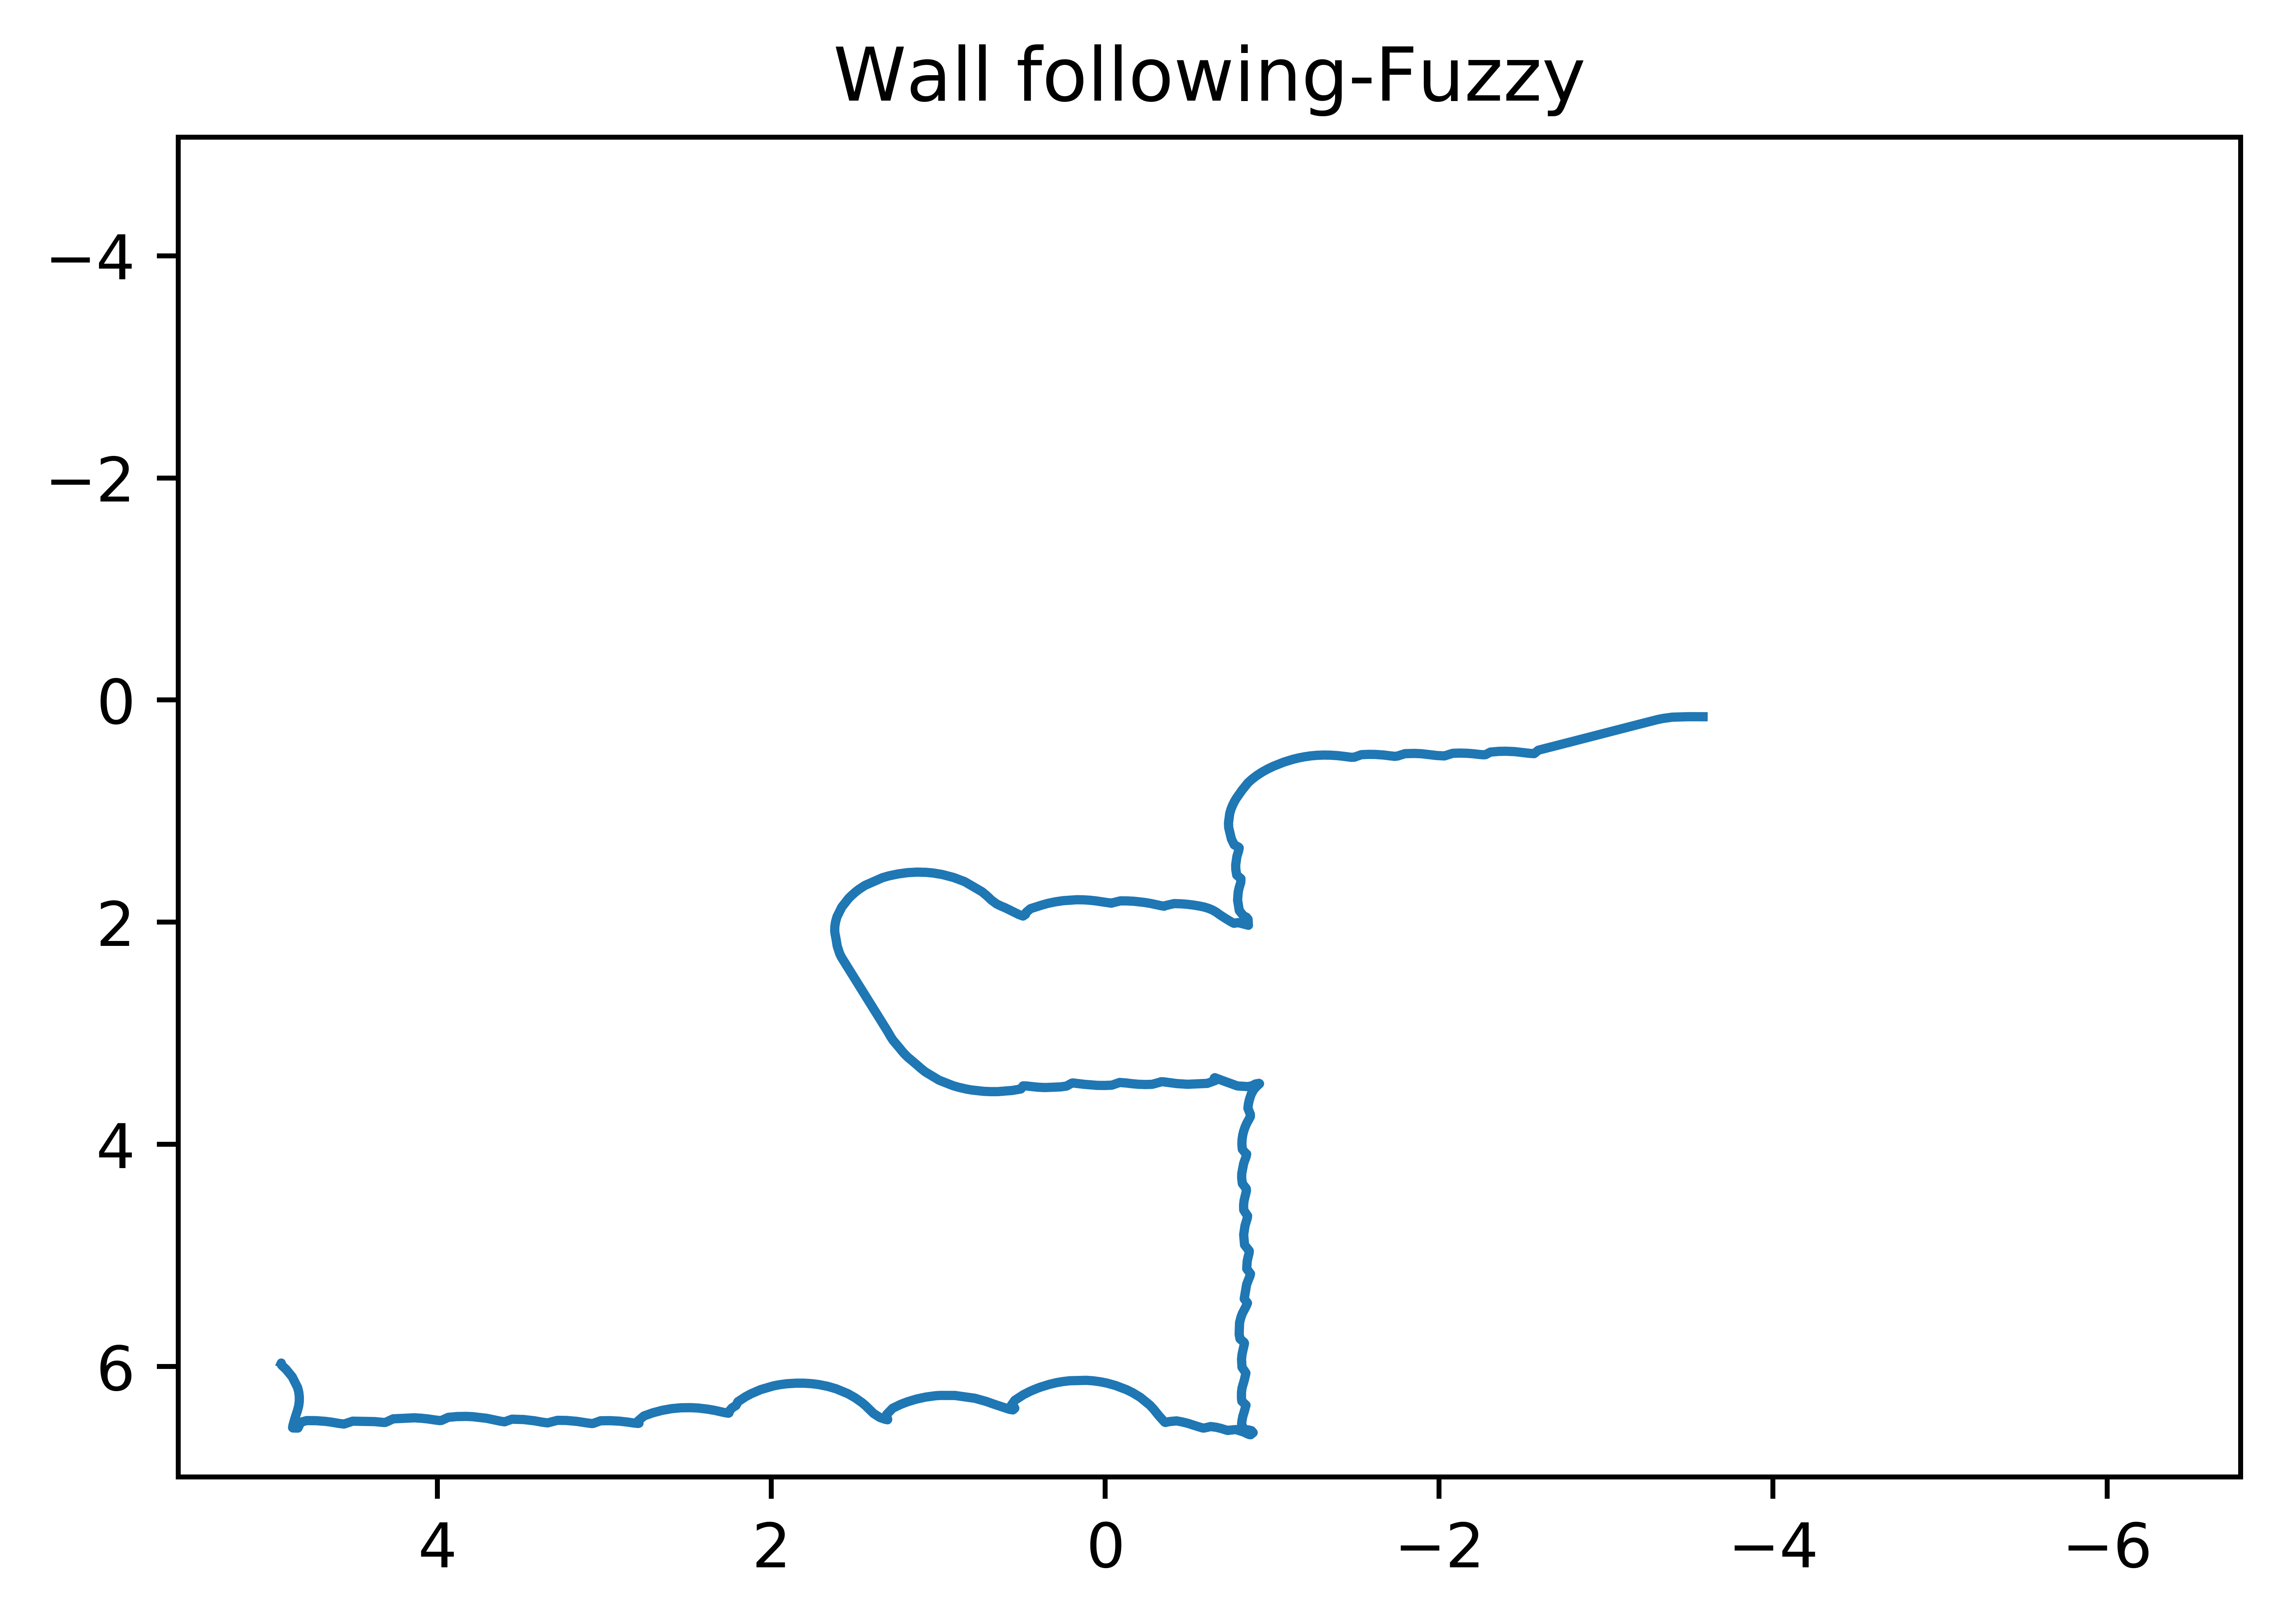

In [39]:
# restarting some connection functions, as it could be a new scenario
vrep.simxLoadScene(clientID, os.getcwd() + "/p3dx_only_doors.ttt", 0, vrep.simx_opmode_blocking)
clientID = connection_vrep()
robot_handle, l_motor_handle, r_motor_handle, l_wheel_handle, r_wheel_handle, sonar_sensor_handles = get_handles()

position_ground_truth = []

set_pos_ori_robot(x=-3.67500e+00, y=0.1500e+00, gamma=-0.0000e+02)

follow_wall_fuzzy(duration=500, signal_ex=True)

In the simulation, we can see that when the robot is further to the wall, the turning speed is really fast, so the threshold for membership function of output variale *Zero* should be smaller. At the end of the simulation, the robot stuck at the walldrobe, the robot stopped because the walldrobe is half-hollow and the sensors detected the distances further than the robot can reach. This case is unavoid due to the drawback of the sonar sensor.

<img src='wall-follow-fuzzy-stuckatwalldrope.png'>


In [ ]:
position_ground_truth = []

set_pos_ori_robot(x=3.6250e+00, y=6.5250e+00, gamma=-0.0000e+02)

follow_wall_fuzzy(duration=500, signal_ex=True)

After delete the walldrobe, we can see that the robot can follow the wall successfully.

**Behavior Coordinator**

In this second part, we developed a state machine with goToGoal and wall following methods. We created a scenario and two experiments, depicted below, where the robot went towards a target position but needed to avoid walls in its way. The target points were $(-5.25, 4.95)$ and $(1.2, 9.175)$. The state machine is simple and based on two rules:

<ol>
<li>goTGoal switches to wall-following when the robot detects any obstacles.</li>
<li>wall-following switches to goToGoal when the robot is closer to the target point than its previous closest position.</li>
</ol>

If the second condition occurs and a wall is in the robot's way, it moves a little bit but the next iteration switches to wall-following again. We mention also that, the robot didn't take the closest path especially because wall-following always turns to the left, however, it de facto reached the two target points. Lastly, our main problem relied on how these two methods could work together and what rules must be satisfied to switch methods.

<img src="scenarios1and2.png">

In [ ]:
def foundBestDistance(best_distance, end_pos):
    xe, ye = end_pos
#     xn, yn, _ = collect_ground_truth()
    z = get_current_position(robot_handle,-1)
    xn = z[0]
    yn = z[1]
    tmpd = sqrt((xe-xn)**2+(ye-yn)**2)
    if tmpd < best_distance:
        return tmpd, True
    return best_distance, False

def isWalls():
    distances = read_sonar_sensors()
    if(distances[0] < 0.2 or distances[1] < 0.2 or distances[2] < 0.4 or distances[3] < 0.3 or distances[4] < 0.3 or distances[15]<0.2):
        return True
    return False
    
    
def stateMachine(init_pos, end_pos, robot_timeout=4*ROBOT_TIMEOUT):
    
#     vrep.simxStopSimulation(clientID,vrep.simx_opmode_blocking)
#     time.sleep(3)
#     vrep.simxStartSimulation(clientID,vrep.simx_opmode_blocking)
    def handler_timeout(signum, frame):
        """ just a timeout handler :) """
        raise Exception

    try:
        vrep.simxStartSimulation(clientID,vrep.simx_opmode_blocking)
        # Set the signal to stop the robot in ROBOT_TIMEOUT seconds
        signal.signal(signal.SIGALRM, handler_timeout)
        signal.alarm(robot_timeout)
        
        xi, yi = init_pos
        xe, ye = end_pos
        stop = False
        duration = 10
        best_distance = sqrt((xe-xi)**2+(ye-yi)**2)

    #     print(1)
        while(sqrt((xi-xe)**2 + (yi-ye)**2) > 0.1):

            stop = False
            while(isWalls() == True and stop == False):
                follow_wall_fuzzy(duration, False)
                best_distance, stop = foundBestDistance(best_distance, end_pos)

            z = get_current_position(robot_handle,-1)
            xi = z[0]
            yi = z[1]
            angle_old = get_current_orientation(robot_handle,-1)
            angle_d = atan2(ye - yi, xe - xi)
            angle = PID(0.75, 0, 0, angle_d - angle_old[2])
            set_velocity(0.3, angle)
            time.sleep(0.3)
            
        vrep.simxStopSimulation(clientID,vrep.simx_opmode_blocking)
        set_velocity_both_motors(0)
    except Exception as e:
        print(e)
        vrep.simxStopSimulation(clientID,vrep.simx_opmode_blocking)
        set_velocity_both_motors(0)

In [ ]:
# # restarting some connection functions, as it could be a new scenario
# vrep.simxCloseScene(clientID, vrep.simx_opmode_blocking)
# vrep.simxLoadScene(clientID, os.getcwd() + "/state-machine.ttt", 0, vrep.simx_opmode_blocking)
# clientID = connection_vrep()
# robot_handle, l_motor_handle, r_motor_handle, l_wheel_handle, r_wheel_handle, sonar_sensor_handles = get_handles()

# init_pos = (2.475, -9.325)
# #end_pos = (-5.25, 4.95)
# end_pos = (1.2, 9.175)
# stateMachine(init_pos, end_pos)

In [ ]:
set_velocity_both_motors(0)